In [180]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/int3405-sentiment-analysis-problem/test.csv
/kaggle/input/int3405-sentiment-analysis-problem/full_train.csv


In [181]:
 !pip install tensorflow==2.0

^C
ERROR: Operation cancelled by user


In [196]:
import os
!pip install pyvi
import numpy as np 
with open('/kaggle/input/int3405-sentiment-analysis-problem/test.csv', encoding="utf8") as f:
    lines = f.readlines()
    lines = "".join(lines)

In [183]:
#Ignoring the warnings
import warnings
warnings.filterwarnings('ignore')
import seaborn as sns

#Importing the required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re, string, unicodedata
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalMaxPooling1D
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import *
from tensorflow.keras import backend
from tensorflow.keras import layers
from sklearn.metrics import f1_score, confusion_matrix
import tensorflow as tf
from pyvi import ViTokenizer
from pyvi import ViUtils

Tập dữ liệu gồm 2 trường:

- Key: “comment”: các văn bản với nội dung đánh giá về quán ăn
- Key: “rating”: là Label cho đoạn văn bản đó có nội dung tích cực hay tiêu cực.

In [184]:
df1 = pd.read_csv('/kaggle/input/int3405-sentiment-analysis-problem/full_train.csv')
df1 = df1.dropna()

df1 = df1.drop(['Unnamed: 0','RevId','UserId','image_urls'], axis=1)
X_train1 = list(df1['Comment'].values)
y_train1 = list(df1['Rating'].values)
print(df1.shape)
df1.head()

(9070, 2)


,Comment,Rating
0,"Xôi dẻo, đồ ăn đậm vị. Hộp xôi được lót lá trô...",1.0
1,Gọi ship 1 xuất cari gà bánh naan và 3 miếng g...,0.0
2,"Thời tiết lạnh như này, cả nhà rủ nhau đến leg...",1.0
3,Em có đọc review thấy mng bảo trà sữa nướng đề...,0.0
4,"Đồ ăn rất ngon, nhà hàng cũng rất đẹp, tất cả ...",1.0


Check DF

In [185]:
# check for length train
X_train = X_train1 #+ X_train2 + X_train3
print(len(X_train))
y_train = y_train1 #+ y_train2 + y_train3
print(len(y_train))

9070
9070


In [186]:
sum(y_train)
print(sum(y_train) / len(y_train))

0.7878721058434399


<AxesSubplot:ylabel='count'>

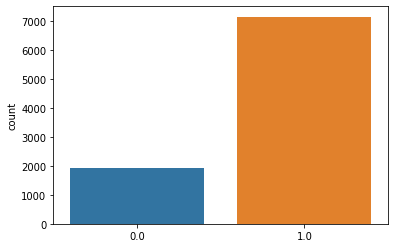

In [188]:
# Check chart output data
sns.countplot(y_train)

Text Preprocessing

In [ ]:
def clean_text_support(text):
    RE_EMOJI = re.compile('[\U00010000-\U0010ffff]', flags=re.UNICODE)
    text = re.sub(r"<.*?>", " ", text)
    text = re.sub(r"\n", " ", text)
    text = re.sub(r"\s{2,}", " ", text)
    text = RE_EMOJI.sub(r'', text)
    return text.strip().lower()

In [ ]:
def clean_text(X):
    processed = []
    for text in X:
        text = clean_text_support(text)
        text = ViTokenizer.tokenize(text)
        processed.append(text)
    return processed

In [ ]:
text_test = X_train[100]
print(text_test)
print('===')
print(X_train[333])

In [190]:
X_train_final = X_train

In [189]:
len(X_train_final)

9070

In [191]:
print(X_train_final[:2])
print("===")
print(y_train[:2])

['Xôi dẻo, đồ ăn đậm vị. Hộp xôi được lót lá trông rất thích', 'Gọi ship 1 xuất cari gà bánh naan và 3 miếng gà nướng(được tặng 1 coca). Đồ ăn khá ngon, tổng 210k được giảm 50k còn 160k. Tuy nhiên gọi 3 miếng gà thì thiếu 1 miếng, mà kể cả đó đủ ba miếng thì khẩu phần vẫn là quá ít so với giá 120k 1 suất.']
===
[1.0, 0.0]


In [ ]:
# Attention Layer
from tensorflow.keras import initializers,regularizers,constraints
from tensorflow.keras import backend as K
class AttentionWithContext(tf.keras.layers.Layer):
    """
    Attention operation, with a context/query vector, for temporal data.
    Supports Masking.
    Follows the work of Yang et al. [https://www.cs.cmu.edu/~diyiy/docs/naacl16.pdf]
    "Hierarchical Attention Networks for Document Classification"
    by using a context vector to assist the attention
    # Input shape
        3D tensor with shape: `(samples, steps, features)`.
    # Output shape
        2D tensor with shape: `(samples, features)`.
    How to use:
    Just put it on top of an RNN Layer (GRU/LSTM/SimpleRNN) with return_sequences=True.
    The dimensions are inferred based on the output shape of the RNN.
    Note: The layer has been tested with Keras 2.0.6
    Example:
        model.add(LSTM(64, return_sequences=True))
        model.add(AttentionWithContext())
        # next add a Dense layer (for classification/regression) or whatever...
    """

    def __init__(self, W_regularizer=None, u_regularizer=None, b_regularizer=None,
                 W_constraint=None, u_constraint=None, b_constraint=None,
                 bias=True, **kwargs):

        self.supports_masking = True
        self.init = initializers.get('glorot_uniform')

        self.W_regularizer = regularizers.get(W_regularizer)
        self.u_regularizer = regularizers.get(u_regularizer)
        self.b_regularizer = regularizers.get(b_regularizer)

        self.W_constraint = constraints.get(W_constraint)
        self.u_constraint = constraints.get(u_constraint)
        self.b_constraint = constraints.get(b_constraint)

        self.bias = bias
        super(AttentionWithContext, self).__init__(**kwargs)

    def build(self, input_shape):
        assert len(input_shape) == 3

        self.W = self.add_weight(shape=(input_shape[-1], input_shape[-1],),
                                 initializer=self.init,
                                 name='{}_W'.format(self.name),
                                 regularizer=self.W_regularizer,
                                 constraint=self.W_constraint)
        if self.bias:
            self.b = self.add_weight(shape=(input_shape[-1],),
                                     initializer='zero',
                                     name='{}_b'.format(self.name),
                                     regularizer=self.b_regularizer,
                                     constraint=self.b_constraint)

        self.u = self.add_weight(shape=(input_shape[-1],),
                                 initializer=self.init,
                                 name='{}_u'.format(self.name),
                                 regularizer=self.u_regularizer,
                                 constraint=self.u_constraint)

        super(AttentionWithContext, self).build(input_shape)

    def compute_mask(self, input, input_mask=None):
        # do not pass the mask to the next layers
        return None
    def get_config(self):
        config = super().get_config().copy()
        config.update({
            'W_regularizer': self.W_regularizer,
            'u_regularizer': self.u_regularizer,
            'b_regularizer': self.b_regularizer,
            'W_constraint': self.W_constraint,
            'u_constraint': self.u_constraint,
            'b_constraint': self.b_constraint,
            'bias': self.bias,
            })
        return config
    def call(self, x, mask=None):
        uit = dot_product(x, self.W)

        if self.bias:
            uit += self.b

        uit = K.tanh(uit)
        ait = dot_product(uit, self.u)

        a = K.exp(ait)

        # apply mask after the exp. will be re-normalized next
        if mask is not None:
            # Cast the mask to floatX to avoid float64 upcasting in theano
            a *= K.cast(mask, K.floatx())

        # in some cases especially in the early stages of training the sum may be almost zero
        # and this results in NaN's. A workaround is to add a very small positive number ε to the sum.
        # a /= K.cast(K.sum(a, axis=1, keepdims=True), K.floatx())
        a /= K.cast(K.sum(a, axis=1, keepdims=True) + K.epsilon(), K.floatx())

        a = K.expand_dims(a)
        weighted_input = x * a
        return K.sum(weighted_input, axis=1)

    def compute_output_shape(self, input_shape):
        return input_shape[0], input_shape[-1]

def dot_product(x, kernel):
    """
    Wrapper for dot product operation, in order to be compatible with both
    Theano and Tensorflow
    Args:
        x (): input
        kernel (): weights
    Returns:
    """
    if K.backend() == 'tensorflow':
        return K.squeeze(K.dot(x, K.expand_dims(kernel)), axis=-1)
    else:
        return K.dot(x, kernel)

In [192]:
# some properties
vocab_size = 60000
maxlen = 250
encode_dim = 20
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train_final)
tokenized_word_list = tokenizer.texts_to_sequences(X_train_final)
X_train_padded = pad_sequences(tokenized_word_list, maxlen = maxlen, padding='post')

In [193]:
#EarlyStopping and ModelCheckpoint
es = EarlyStopping(monitor = 'val_loss', mode = 'min', verbose = 1, patience = 5)
mc = ModelCheckpoint('model_best.h5', monitor = 'val_loss', mode = 'min', verbose = 1, save_best_only = True)

Building model train

In [ ]:
import tensorflow_addons as tfa

In [194]:
# Build model
def create_model():
    model = Sequential()
    embed = Embedding(input_dim = vocab_size, output_dim = 20, input_length = X_train_padded.shape[1]) 
    model.add(embed)
    model.add(Dropout(0.4))
    model.add(Bidirectional(LSTM(200, return_sequences = True)))
    model.add(Dropout(0.3))
    model.add(AttentionWithContext())
    model.add(Dropout(0.3))
    model.add(Dense(512))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dense(256))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dense(1, activation = 'sigmoid'))
    model.summary()
    return model

Traning model

In [ ]:
from sklearn.model_selection import train_test_split
X_train_padded = np.asarray(X_train_padded)
y_train = np.asarray(y_train)
X_train_final2 = X_train_padded
y_train_final2 = y_train
weight = sum(y_train_final2) / y_train_final2.shape[0]

In [ ]:
#class weight
weight_for_0 = (1 / (1-(weight))) * 0.5
weight_for_1 = (1 / (weight))* 0.5
class_weight = {0: weight_for_0, 1: weight_for_1}

In [ ]:
es = EarlyStopping(monitor = 'val_loss', mode = 'min', verbose = 1, patience = 5)
mc = ModelCheckpoint('model_best.h5', monitor = 'f1_score', mode = 'min', verbose = 1, save_best_only = True)
batch_size= 300
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='f1_score', factor=0.2,
                              patience=3, min_lr=1e-5,verbose = 1)

In [ ]:
tpu_strategy = tf.distribute.MirroredStrategy()

In [ ]:
# instantiating the model in the strategy scope creates the model on the TPU
with tpu_strategy.scope():
    model = create_model() # define your model normally
    optim =  tf.keras.optimizers.Adam(learning_rate=5e-4)

    model.compile(optimizer='adam',
                     loss='binary_crossentropy',
                     metrics=['accuracy',
                              tf.keras.metrics.Recall(),
                              tfa.metrics.F1Score(num_classes=1,
                                                 average='micro')
                             ]
             )

In [ ]:
len(X_train_final2)

In [ ]:
train_x, train_y = np.array(X_train_final2), np.array(y_train_final2)
train_data = tf.data.Dataset.from_tensor_slices((train_x, train_y))

In [ ]:
batch_size = 512 * tpu_strategy.num_replicas_in_sync

train_data = train_data.batch(batch_size)
# val_data = val_data.batch(batch_size)
# Disable AutoShard.
options = tf.data.Options()
options.experimental_distribute.auto_shard_policy = tf.data.experimental.AutoShardPolicy.OFF
train_data = train_data.with_options(options)
# val_data = val_data.with_options(options)

In [ ]:
#Fit model
model.fit(train_data ,
          epochs = 15, batch_size = batch_size, verbose = 1,
          callbacks = [reduce_lr, es,mc],class_weight=class_weight)

In [195]:
df = pd.read_csv('/kaggle/input/int3405-sentiment-analysis-problem/test.csv')
data_test = pd.DataFrame({'input':df['Comment'],'id':df["RevId"]})
X_test = list(data_test['input'].values)

def clean_text_test(X):
    idx = 0
    y_train = []
    processed = []
    for text in X:
        text = str(text)
        text = clean_text_support(text)
        input_text_pre_accent = ViTokenizer.tokenize(text)
        processed.append(input_text_pre_accent)
    return processed
# X_test = list()
X_test_final = clean_text_test(X_test)

In [ ]:
my_submission['Rating'].sum() / len(my_submission['Rating'])

In [ ]:
my_submission = pd.DataFrame({'RevId': np.array(df["RevId"]).reshape(5103), 'Rating': np.array(y_pred).reshape(5103)})
my_submission.to_csv('submission.csv', index=False)